In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import lambertw
from numpy import exp, log, e
%matplotlib inline

# Fitting Various Alpha Values

In [12]:
def lambertDecay(t, alpha, tau, sigma_21, n20):
    arg = -alpha*sigma_21*n20*exp(-(t+alpha*sigma_21*n20*tau)/tau)
    return -lambertw(arg).real/(alpha*sigma_21)

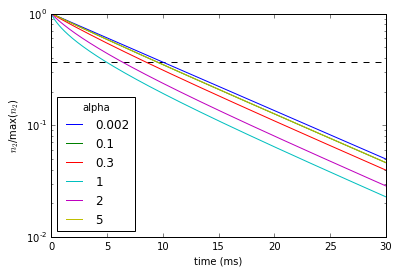

In [13]:
t = np.linspace(0,30,1000)
tau = 10
sigma_21 = 1
n20 = 0.8  # Fraction of population inversion (>0.5)

plt.figure()
plt.axhline(1/np.e, ls='--', color='k')
plt.ylabel('$n_2$/max($n_2$)')
plt.xlabel('time (ms)')

for alpha in [0.002, 0.1, 0.3, 1, 2, 5]:
    n = lambertDecay(t, alpha,tau,sigma_21,n20)
    
    # Select only part of curve that is completely real
#     index = np.where(np.isreal(n))
#     t = t[index]
#     n = n[index].real
    
    plt.plot(t,n/max(n), label=alpha)

plt.xlim(min(t),max(t))
plt.yscale('log')
plt.legend(loc='best', title='alpha')
# plt.savefig('decaysVsAlphac.png', dpi=300)

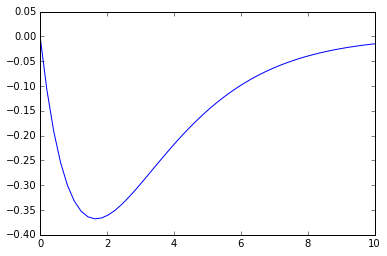

In [32]:
arg = []
a = np.linspace(0,10)
for alpha in a:
    arg.append(min(-alpha*sigma_21*n20*exp(-(t+alpha*sigma_21*n20*tau)/tau)))
plt.plot(a,arg)

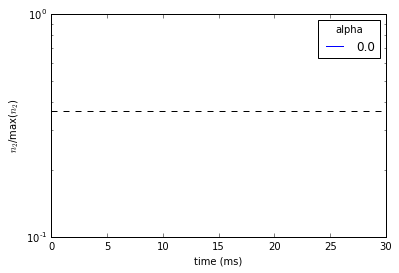

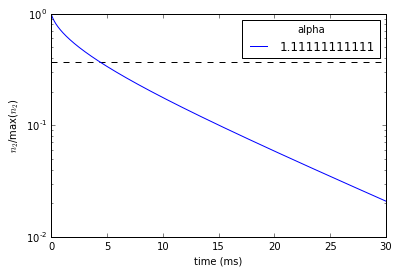

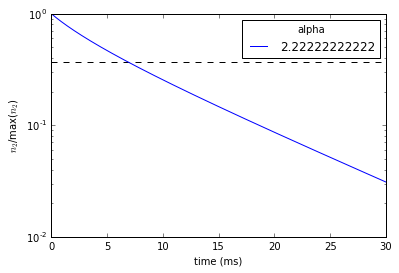

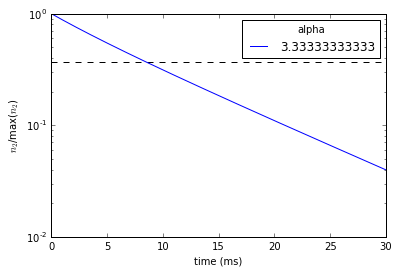

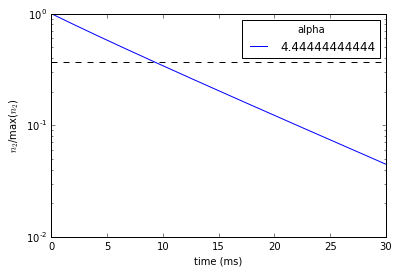

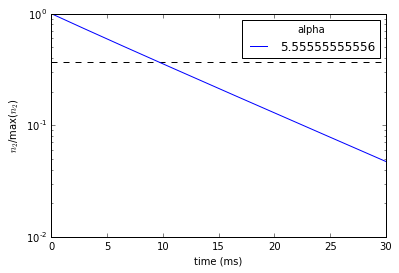

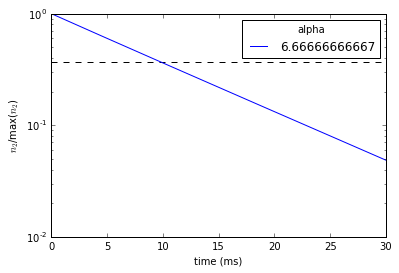

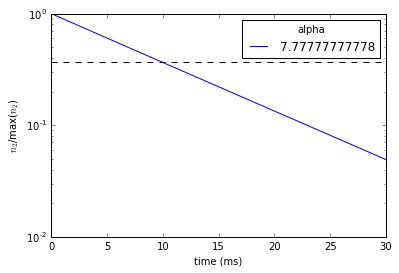

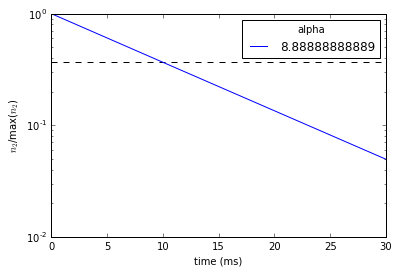

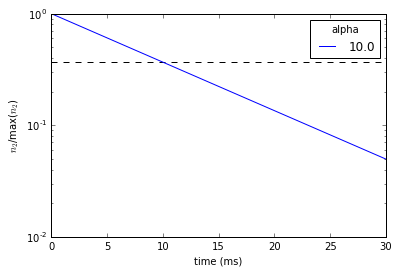

In [19]:
t = np.linspace(0,30,1000)
tau = 10
sigma_21 = 1
n20 = 0.8  # Fraction of population inversion (>0.5)

for alpha in np.linspace(0, 5, 100):
    n = lambertDecay(t, alpha,tau,sigma_21,n20)
    
    # Select only part of curve that is completely real
#     index = np.where(np.isreal(n))
#     t = t[index]
#     n = n[index].real
    
    plt.figure()
    plt.axhline(1/np.e, ls='--', color='k')
    plt.ylabel('$n_2$/max($n_2$)')
    plt.xlabel('time (ms)')
    plt.xlim(min(t),max(t))
    plt.yscale('log')
    plt.plot(t,n/max(n), label=alpha)
    plt.legend(loc='best', title='alpha')
    plt.savefig(str(alpha)+'.png', dpi=300)

# Fitting

### Fitting with minimize
http://stackoverflow.com/questions/16760788/python-curve-fit-library-that-allows-me-to-assign-bounds-to-parameters


([1, 0.8], array([ 1.04494877,  0.84246929]))

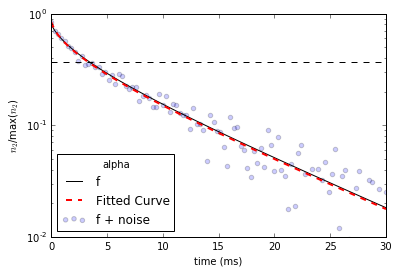

In [5]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize

def model_func(t, *p):
    
    def lambertDecay(t, *p):
        sigma_21 = 1
        tau = 10
#         n20 = 0.8
        alpha, n20 = p
        arg = -alpha*sigma_21*n20*exp(-(t+alpha*sigma_21*n20*tau)/tau)
        return -lambertw(arg)/(alpha*sigma_21)

    n = lambertDecay(t, *p)
    
    return n.real

# generate noisy data with known coefficients
alpha = 1
n20 = 0.8 

p0 = [alpha, n20]  # Guess for dependent data
t = np.linspace(0,30,100)
n = model_func(t,*p0)
data = n + np.random.normal(0, 0.02, np.size(n))

## mean squared error wrt. noisy data as a function of the parameters
# err = lambda p: np.mean((model_func(t,*p)-data)**2)

# Sum-Squared-Error Cost Function wrt. noisy data as a function of the parameters
err = lambda p: np.sum((data-model_func(t,*p))**2)

# bounded optimization using scipy.minimize
p_init = p0
popt = minimize(
    err, # minimize wrt to the noisy data
    p_init, 
    bounds=[(0,None),(0.5,1)], # set the bounds
    method="L-BFGS-B" # this method supports bounds
).x

# plot everything
plt.figure()
plt.scatter(t, data, alpha=.2, label='f + noise')
plt.plot(t, n, 'k-', label='f')
plt.plot(t, model_func(t, *popt), 'r--', lw=2, label="Fitted Curve")

plt.axhline(1/np.e, ls='--', color='k')
plt.legend(loc='best', title='alpha')
plt.ylabel('$n_2$/max($n_2$)')
plt.xlabel('time (ms)')
plt.xlim(min(t),max(t))
plt.yscale('log')

p0, popt

### Fitting with Curve_fit

(array([ 0.99990635,  0.80063538]), [1, 0.8])

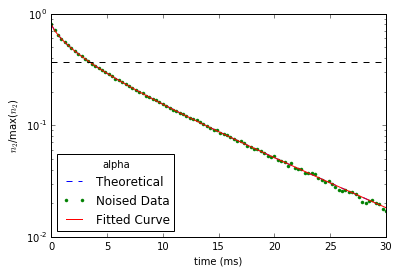

In [10]:
from scipy.optimize import curve_fit


def model_func(t, *p):
    
    def lambertDecay(t, *p):
        sigma_21 = 1
        tau = 10
#         n20 = 0.8
        alpha, n20 = p
        arg = -alpha*sigma_21*n20*exp(-(t+alpha*sigma_21*n20*tau)/tau)
        return -lambertw(arg)/(alpha*sigma_21)

    n = lambertDecay(t, *p)
    
    return n.real

# Guess for dependent data
p0 = [alpha, n20]

# Fit data to model using Levenberg-Marquardt algorithm
# trf method gives right parameters but 'lm' (Levenberg-Marquardt) swaps them. trf can take bounds.
popt, pcov = curve_fit(model_func, t, data, p0=p0, method='trf')
# popt, pcov = curve_fit(model_func, t, data, p0=p0, bounds=[(0,None),(0.5,1)], method='trf')

plt.figure()
plt.semilogy(t,n, '--', label='Theoretical')

# Add 1% noise to theoretical fit to create data
data = n + np.random.normal(0, 0.001, np.size(n))
plt.semilogy(t,data, '.', label='Noised Data')

# Fit model
plt.plot(t, model_func(t, *popt), 'r-', label="Fitted Curve")

plt.axhline(1/np.e, ls='--', color='k')
plt.legend(loc='best', title='alpha')
plt.ylabel('$n_2$/max($n_2$)')
plt.xlabel('time (ms)')

popt, p0